## 0. 데이터 로드

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.stattools import jarque_bera
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.style.use("seaborn-v0_8")
plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["axes.grid"] = True
plt.rcParams['font.family'] = 'AppleGothic'

In [3]:
DATA_PATH = "../data/kospi_df.csv"   # TODO: 네 파일 이름으로 수정

df = pd.read_csv(DATA_PATH)

# date 파싱 & 정렬
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values("date").reset_index(drop=True)

df.head()

,date,close,high,low,open,volume,ret_1d,ret_5d,ret_22d,ma_5,...,momentum_60,drawdown_60,max_drawdown_60,usdkrw,gold_price,vix,news_emotion,forward_return,rolling_5yr_mean,market_forward_excess_returns
0,2005-01-03,893.710022,897.590027,890.929993,896.000000,252600,-0.002467,0.015672,0.019286,885.862000,...,12.330017,-0.002467,-0.089368,1027.300049,428.700012,14.08,101.07,-0.007620,0.000074,-0.007694
1,2005-01-04,886.900024,895.400024,884.940002,890.559998,331600,-0.007620,0.011312,0.003167,887.846008,...,5.790039,-0.010068,-0.089368,1028.699951,428.500000,13.98,101.52,-0.001928,0.000072,-0.002000
2,2005-01-05,885.190002,885.200012,873.179993,874.919983,343100,-0.001928,0.007696,0.002991,889.198010,...,27.099976,-0.011976,-0.089368,1035.800049,426.600006,14.09,102.00,-0.015714,0.000059,-0.015773
3,2005-01-06,871.280029,886.309998,871.280029,878.229981,394700,-0.015714,-0.014690,0.000609,886.600012,...,15.100037,-0.027502,-0.089368,1048.400024,421.000000,13.58,101.45,-0.000505,0.000059,-0.000564
4,2005-01-07,870.840027,878.890015,866.719971,876.359985,294800,-0.000505,-0.027994,0.011346,881.584021,...,24.210022,-0.027994,-0.089368,1045.099976,418.899994,13.49,102.14,0.003835,0.000062,0.003773


In [4]:
df.columns

Index(['date', 'close', 'high', 'low', 'open', 'volume', 'ret_1d', 'ret_5d',
       'ret_22d', 'ma_5', 'ma_20', 'ma_60', 'ma_120', 'vol_22d', 'rsi_14',
       'macd', 'macd_signal', 'macd_hist', 'atr_14', 'bb_middle', 'bb_upper',
       'bb_lower', 'momentum_10', 'momentum_20', 'momentum_60', 'drawdown_60',
       'max_drawdown_60', 'usdkrw', 'gold_price', 'vix', 'news_emotion',
       'forward_return', 'rolling_5yr_mean', 'market_forward_excess_returns'],
      dtype='object')

In [5]:
def overview_dataset(df: pd.DataFrame, name="df"):
    print(f"=== [{name}] BASIC INFO ===")
    print("Shape:", df.shape)
    print("기간:", df["date"].min(), "→", df["date"].max())
    print("행 개수 (unique dates):", df["date"].nunique())
    print()

    print("Dtypes (value_counts):")
    print(df.dtypes.value_counts())
    print()

    print("숫자형 컬럼 수:", df.select_dtypes(include=[np.number]).shape[1])
    print("비숫자형 컬럼:", [c for c in df.columns if df[c].dtype == "object"])
    print()

    print("=== Missing Values (Top 20) ===")
    mis = df.isna().sum()
    mis = mis[mis > 0].sort_values(ascending=False)
    display(mis.head(20))

overview_dataset(df, name="all")

=== [all] BASIC INFO ===
Shape: (4933, 34)
기간: 2005-01-03 00:00:00 → 2024-12-27 00:00:00
행 개수 (unique dates): 4933

Dtypes (value_counts):
float64           32
datetime64[ns]     1
int64              1
Name: count, dtype: int64

숫자형 컬럼 수: 33
비숫자형 컬럼: []

=== Missing Values (Top 20) ===


Series([], dtype: int64)

In [6]:
# 숫자형 컬럼 전체 기술통계 (상위 20개만 미리 보기)
num_desc = df.select_dtypes(include=[np.number]).describe().T
num_desc.head(20)

,count,mean,std,min,25%,50%,75%,max
close,4933.0,2019.635842,491.044673,870.840027,1755.030029,2001.469971,2355.050049,3.305210e+03
high,4933.0,2031.147462,492.857509,875.000000,1765.810059,2009.670044,2367.840088,3.316080e+03
low,4933.0,2007.204805,490.055895,866.169983,1740.109985,1991.810059,2340.189941,3.295440e+03
open,4933.0,2020.750933,491.604938,872.820007,1753.670044,2001.979980,2353.919922,3.305460e+03
volume,4933.0,468899.797284,251053.596608,0.000000,317700.000000,402400.000000,534300.000000,3.455500e+06
ret_1d,4933.0,0.000275,0.012220,-0.105705,-0.005310,0.000620,0.006558,1.194567e-01
ret_5d,4933.0,0.001406,0.027484,-0.216275,-0.012319,0.003281,0.016732,2.193360e-01
ret_22d,4933.0,0.006223,0.056035,-0.367338,-0.024738,0.007248,0.038770,2.915897e-01
ma_5,4933.0,2019.013064,491.070674,876.124011,1754.571997,2000.055981,2352.826025,3.294838e+03
ma_20,4933.0,2016.622084,491.454469,872.880502,1762.689502,1996.015503,2356.407007,3.276349e+03


In [7]:
df = df.sort_values("date").reset_index(drop=True)

train_ratio = 0.85
cutoff_idx = int(len(df) * train_ratio)

df["is_train"] = 0
df.loc[:cutoff_idx, "is_train"] = 1

In [10]:
target_col = "market_forward_excess_returns"

# forward_return / forward_returns 중 있는 걸 벤치마크로 사용
if "forward_return" in df.columns:
    benchmark_col = "forward_return"
elif "forward_returns" in df.columns:
    benchmark_col = "forward_returns"
else:
    benchmark_col = target_col  # 없으면 타깃으로 대체

# risk_free_rate가 있으면 같이 쓰고, 없으면 None
rf_col = "risk_free_rate" if "risk_free_rate" in df.columns else None

# is_train 있으면 그걸로 split, 없으면 전체를 train으로
if "is_train" in df.columns:
    train_mask = df["is_train"] == 1
else:
    train_mask = np.ones(len(df), dtype=bool)

train_df = df[train_mask].copy()
test_df  = df[~train_mask].copy()

print("Train shape:", train_df.shape)
print("Test shape :", test_df.shape)
print("Target col :", target_col)
print("Benchmark  :", benchmark_col, "| Risk-free:", rf_col)

Train shape: (4194, 35)
Test shape : (739, 35)
Target col : market_forward_excess_returns
Benchmark  : forward_return | Risk-free: None


### 타깃 계열 기본 EDA

=== Target 기본 통계 ===
count    4194.000000
mean        0.000121
std         0.010278
min        -0.024647
25%        -0.005290
50%         0.000365
75%         0.006188
max         0.025545
Name: market_forward_excess_returns, dtype: float64

[ADF Test] stat = -63.6098, p = 0
[Jarque–Bera] stat = 39.8372, p = 2.236e-09
[Shapiro–Wilk] stat = 0.9821, p = 1.238e-22 (n=4194)


/var/folders/_x/1dj45gqx4m95yc49m_ty7t_00000gn/T/ipykernel_7343/411238211.py:28: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) AppleGothic.
  plt.tight_layout()
/Users/youjunglee/머러플_P4-2/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) AppleGothic.
  fig.canvas.print_figure(bytes_io, **kw)


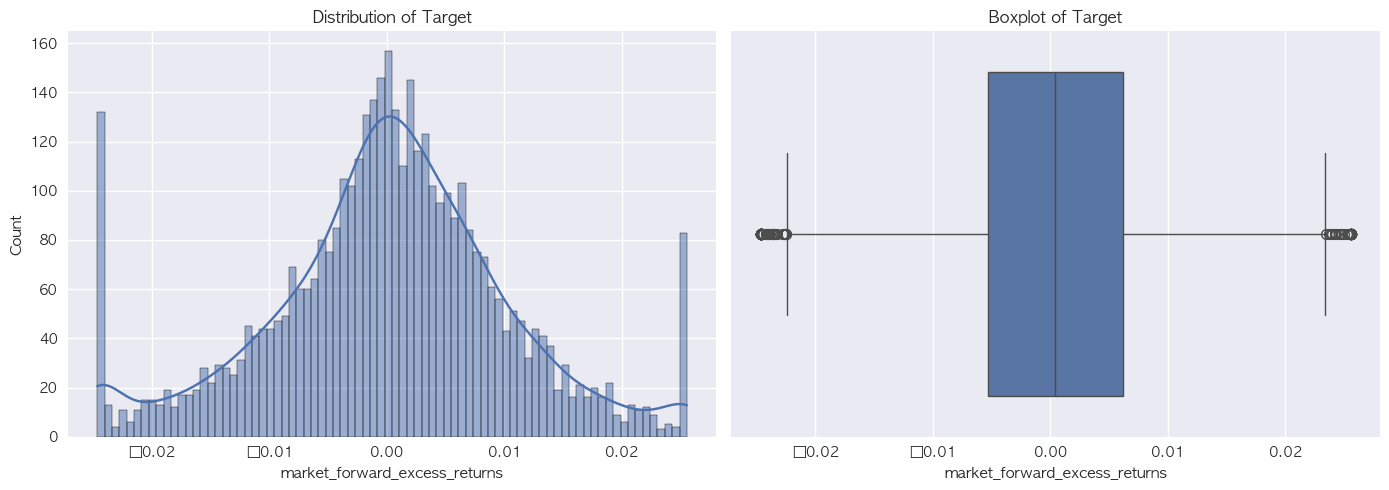

In [11]:
y = train_df[target_col].dropna()

print("=== Target 기본 통계 ===")
print(y.describe())

# ADF
adf_stat, adf_p, *_ = adfuller(y)
print("\n[ADF Test] stat = %.4f, p = %.4g" % (adf_stat, adf_p))

# Jarque–Bera
jb_stat, jb_p, _, _ = jarque_bera(y)
print("[Jarque–Bera] stat = %.4f, p = %.4g" % (jb_stat, jb_p))

# Shapiro-Wilk (앞 5000개 샘플)
sample = y.sample(min(5000, len(y)), random_state=42)
sw_stat, sw_p = stats.shapiro(sample)
print("[Shapiro–Wilk] stat = %.4f, p = %.4g (n=%d)" % (sw_stat, sw_p, len(sample)))

# 분포 그림
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.histplot(y, bins=80, kde=True, ax=axes[0])
axes[0].set_title("Distribution of Target")

sns.boxplot(x=y, ax=axes[1])
axes[1].set_title("Boxplot of Target")

plt.tight_layout()
plt.show()

### Time-Series 특성 파악 (가격, 리턴, 변동성)

/var/folders/_x/1dj45gqx4m95yc49m_ty7t_00000gn/T/ipykernel_7343/2857686337.py:18: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) AppleGothic.
  plt.tight_layout()


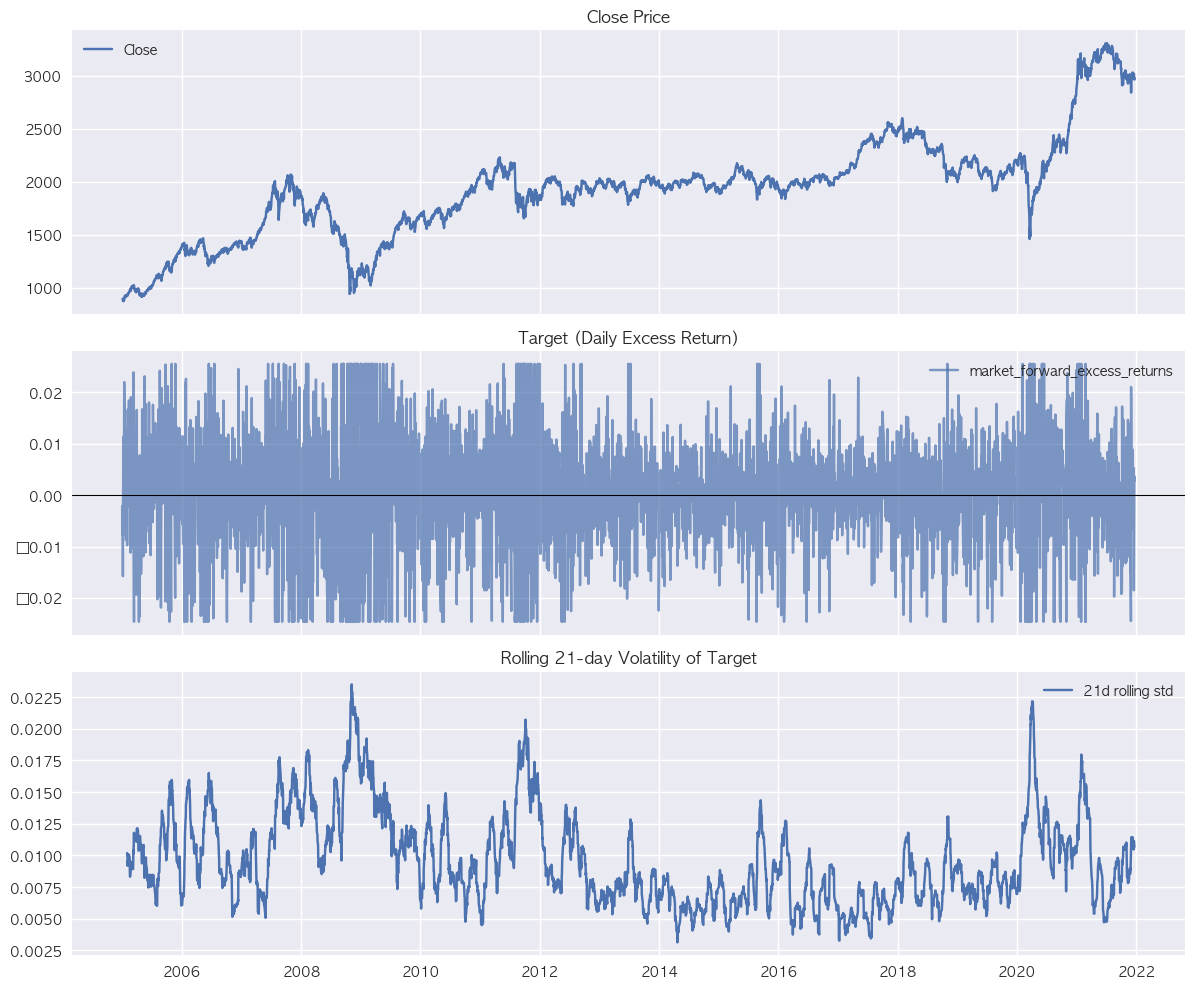

In [12]:
fig, axes = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

axes[0].plot(train_df["date"], train_df["close"], label="Close")
axes[0].set_title("Close Price")
axes[0].legend()

axes[1].plot(train_df["date"], train_df[target_col], label=target_col, alpha=0.7)
axes[1].set_title("Target (Daily Excess Return)")
axes[1].axhline(0, color="black", linewidth=0.8)
axes[1].legend()

# 21일 롤링 변동성
rolling_vol = train_df[target_col].rolling(21).std()
axes[2].plot(train_df["date"], rolling_vol, label="21d rolling std")
axes[2].set_title("Rolling 21-day Volatility of Target")
axes[2].legend()

plt.tight_layout()
plt.show()

### ACF, PACF를 통한 자기상관 구조 파악

/var/folders/_x/1dj45gqx4m95yc49m_ty7t_00000gn/T/ipykernel_7343/1701392181.py:9: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) AppleGothic.
  plt.tight_layout()
/Users/youjunglee/머러플_P4-2/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) AppleGothic.
  fig.canvas.print_figure(bytes_io, **kw)


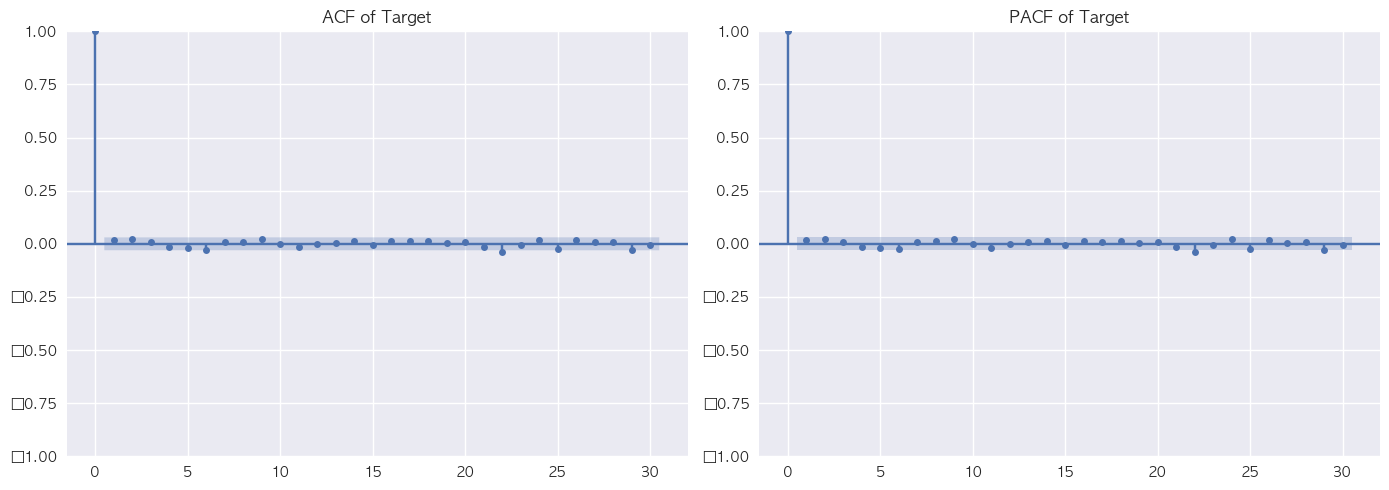

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

plot_acf(y, lags=30, ax=axes[0])
axes[0].set_title("ACF of Target")

plot_pacf(y, lags=30, ax=axes[1])
axes[1].set_title("PACF of Target")

plt.tight_layout()
plt.show()

=== 월별 Target 통계 ===


,mean,std,count
month,,,
1,-0.000184,0.011078,353
2,-0.000340,0.010881,318
3,0.000715,0.010369,364
4,0.000948,0.008799,358
5,-0.000262,0.009976,336
6,-0.000408,0.010146,350
7,0.000686,0.009432,374
8,-0.000555,0.010723,362
9,0.000609,0.010381,333


/var/folders/_x/1dj45gqx4m95yc49m_ty7t_00000gn/T/ipykernel_7343/1781479571.py:29: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) AppleGothic.
  plt.tight_layout()
/Users/youjunglee/머러플_P4-2/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) AppleGothic.
  fig.canvas.print_figure(bytes_io, **kw)


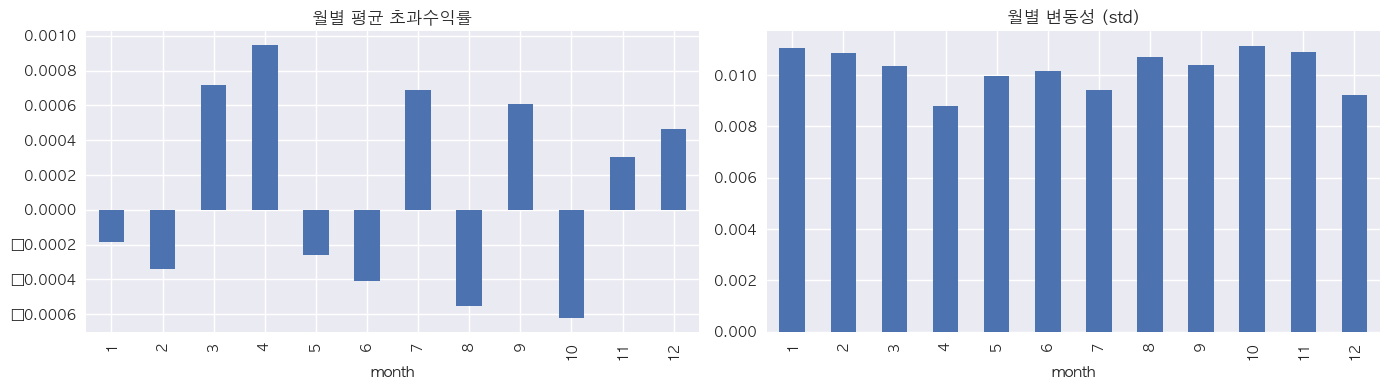

=== 요일별 Target 통계 (0=Mon) ===


,mean,std,count
dow,,,
0,0.000399,0.009489,833
1,0.000313,0.010163,843
2,0.000205,0.010519,834
3,-0.000089,0.010541,847
4,-0.000221,0.010640,837


/Users/youjunglee/머러플_P4-2/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) AppleGothic.
  fig.canvas.print_figure(bytes_io, **kw)


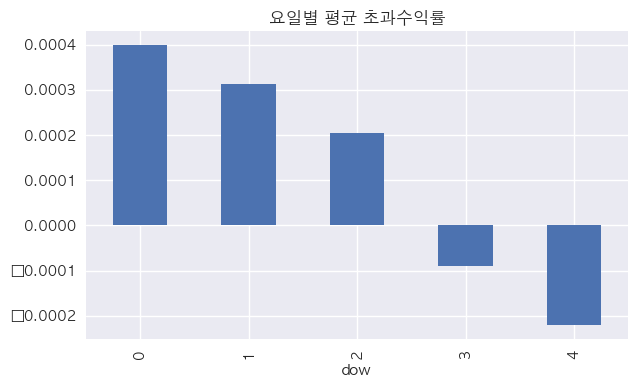

=== 월초/중순/말 Target 통계 ===


,mean,std,count
month_part,,,
early,-0.000047,0.010387,1336
mid,-0.000003,0.010221,1406
late,0.000395,0.010234,1452


/Users/youjunglee/머러플_P4-2/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) AppleGothic.
  fig.canvas.print_figure(bytes_io, **kw)


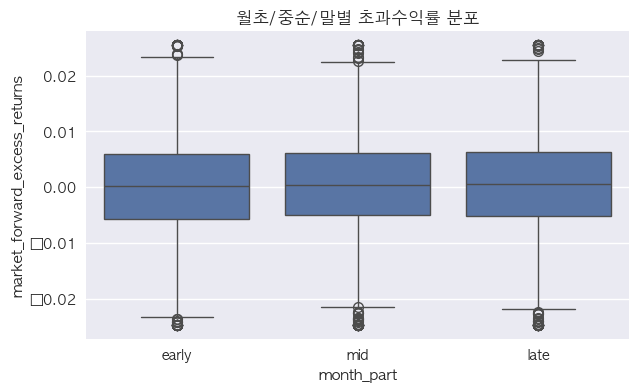

In [14]:
df["year"]  = df["date"].dt.year
df["month"] = df["date"].dt.month
df["day"]   = df["date"].dt.day
df["dow"]   = df["date"].dt.dayofweek  # 0=Mon

# 월 내 n번째 주
df["week_of_month"] = ((df["day"] - 1) // 7 + 1).astype(int)

def month_part_func(day):
    if day <= 10:  return "early"
    if day <= 20:  return "mid"
    return "late"

df["month_part"] = df["day"].apply(month_part_func)

train_df = df.loc[train_mask].copy()
test_df  = df.loc[~train_mask].copy()

# 월별
monthly = train_df.groupby("month")[target_col].agg(["mean", "std", "count"])
print("=== 월별 Target 통계 ===")
display(monthly)

fig, axes = plt.subplots(1, 2, figsize=(14, 4))
monthly["mean"].plot(kind="bar", ax=axes[0])
axes[0].set_title("월별 평균 초과수익률")
monthly["std"].plot(kind="bar", ax=axes[1])
axes[1].set_title("월별 변동성 (std)")
plt.tight_layout()
plt.show()

# 요일별
dow_stats = train_df.groupby("dow")[target_col].agg(["mean", "std", "count"])
print("=== 요일별 Target 통계 (0=Mon) ===")
display(dow_stats)

plt.figure(figsize=(7, 4))
dow_stats["mean"].plot(kind="bar")
plt.title("요일별 평균 초과수익률")
plt.show()

# 월초/중순/말
mp_stats = train_df.groupby("month_part")[target_col].agg(["mean", "std", "count"]).reindex(["early","mid","late"])
print("=== 월초/중순/말 Target 통계 ===")
display(mp_stats)

plt.figure(figsize=(7, 4))
sns.boxplot(data=train_df, x="month_part", y=target_col, order=["early","mid","late"])
plt.title("월초/중순/말별 초과수익률 분포")
plt.show()


### IQR 기준 이상치 값 파악

In [15]:
num_cols_all = train_df.select_dtypes(include=[np.number]).columns.tolist()

summary = []
for c in num_cols_all:
    x = train_df[c].dropna()
    if x.empty:
        continue
    q1, q3 = x.quantile([0.25, 0.75])
    iqr = q3 - q1
    lower, upper = q1 - 1.5 * iqr, q3 + 1.5 * iqr
    outliers = ((x < lower) | (x > upper)).sum()
    summary.append((c, outliers, outliers / len(x) * 100))

outlier_df = pd.DataFrame(summary, columns=["feature", "outliers", "percent"]).sort_values("percent", ascending=False)
print("=== IQR 기준 Outlier 비율 상위 15개 ===")
outlier_df.head(15)

=== IQR 기준 Outlier 비율 상위 15개 ===


,feature,outliers,percent
0,close,398,9.489747
1,high,397,9.465904
3,open,394,9.394373
19,bb_upper,391,9.322842
2,low,391,9.322842
11,ma_120,387,9.227468
8,ma_5,387,9.227468
18,bb_middle,376,8.965188
9,ma_20,376,8.965188
10,ma_60,375,8.941345


### 전체 수치 피처 간 상관관계 히트맵

/Users/youjunglee/머러플_P4-2/.venv/lib/python3.11/site-packages/seaborn/utils.py:61: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) AppleGothic.
  fig.canvas.draw()
/Users/youjunglee/머러플_P4-2/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) AppleGothic.
  fig.canvas.print_figure(bytes_io, **kw)


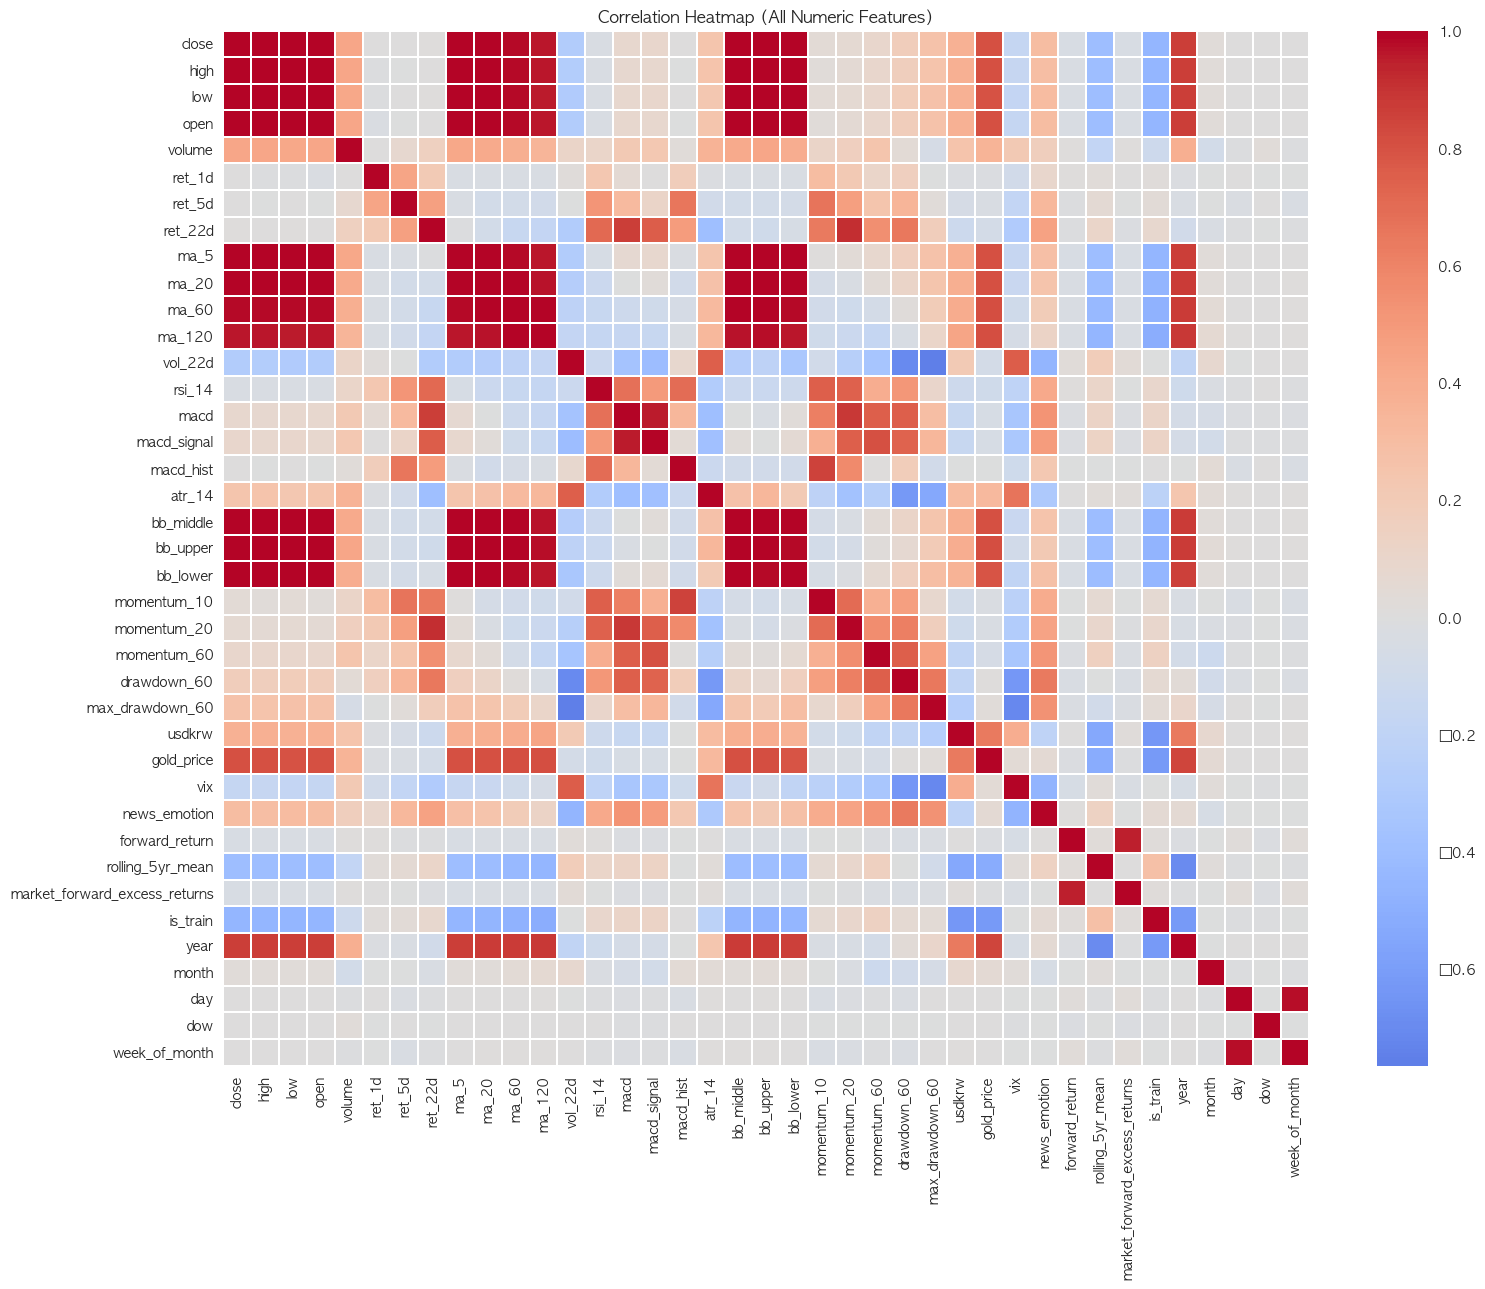

=== Target와 상관계수 상위 20개 ===


market_forward_excess_returns    1.000000
forward_return                   0.949749
vol_22d                          0.036527
week_of_month                    0.027093
day                              0.022043
usdkrw                           0.017467
atr_14                           0.017046
is_train                         0.015025
volume                           0.010019
rolling_5yr_mean                 0.006178
ret_1d                           0.002177
rsi_14                           0.000069
news_emotion                    -0.001016
month                           -0.001550
macd_hist                       -0.002297
ret_5d                          -0.005158
momentum_10                     -0.005454
momentum_20                     -0.006855
year                            -0.010839
gold_price                      -0.011013
Name: market_forward_excess_returns, dtype: float64

In [16]:
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
corr_all = df[numeric_cols].corr()

plt.figure(figsize=(16, 13))
sns.heatmap(corr_all, cmap="coolwarm", center=0, linewidths=0.05)
plt.title("Correlation Heatmap (All Numeric Features)")
plt.tight_layout()
plt.show()

# 타깃과의 상관계수만 따로 보기
corr_with_target = corr_all[target_col].sort_values(ascending=False)
print("=== Target와 상관계수 상위 20개 ===")
corr_with_target.head(20)

### Price / Volatility / Macro / Sentiment 그룹 별 EDA

Price           : 11 cols -> ['close', 'open', 'high', 'low', 'ma_5', 'ma_20', 'ma_60', 'ma_120', 'bb_middle', 'bb_upper', 'bb_lower']


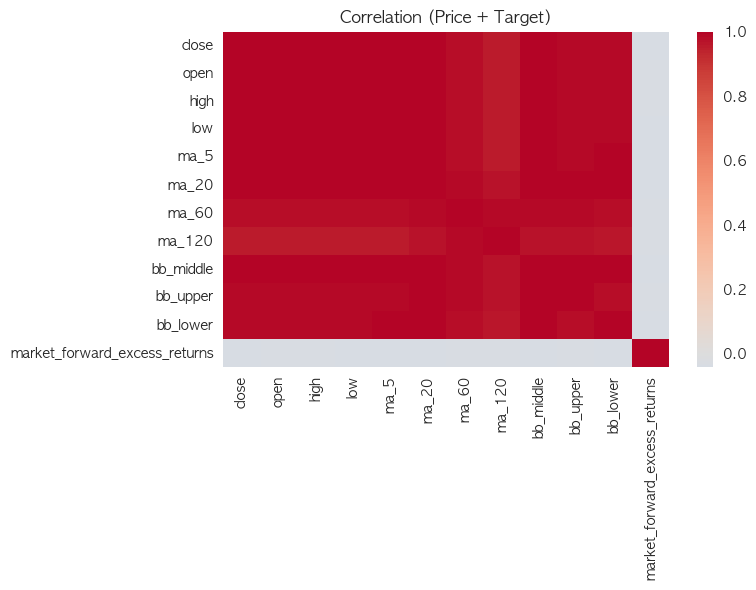

Returns & Momentum: 8 cols -> ['ret_1d', 'ret_5d', 'ret_22d', 'momentum_10', 'momentum_20', 'momentum_60', 'drawdown_60', 'max_drawdown_60']


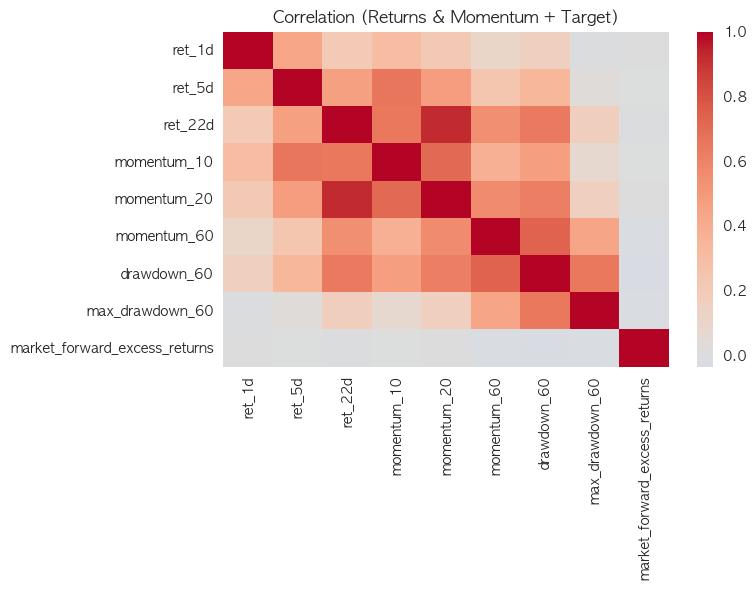

Volatility      : 3 cols -> ['vol_22d', 'atr_14', 'vix']


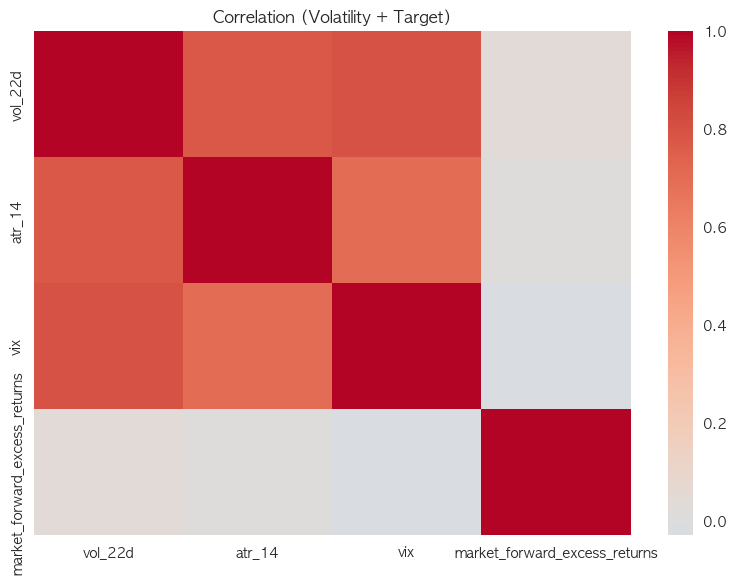

Macro           : 2 cols -> ['usdkrw', 'gold_price']


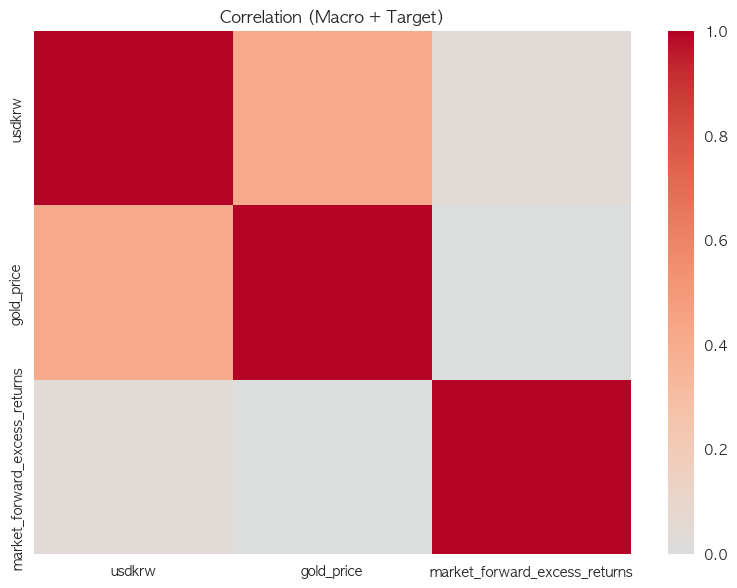

Sentiment       : 1 cols -> ['news_emotion']


In [17]:
PRICE_COLS = ["close","open","high","low",
              "ma_5","ma_20","ma_60","ma_120",
              "bb_middle","bb_upper","bb_lower"]
RET_COLS   = ["ret_1d","ret_5d","ret_22d",
              "momentum_10","momentum_20","momentum_60",
              "drawdown_60","max_drawdown_60"]
VOL_COLS   = ["vol_22d","atr_14","vix"]
MACRO_COLS = ["usdkrw","gold_price"]
SENT_COLS  = ["news_emotion"] if "news_emotion" in df.columns else []

groups = {
    "Price": PRICE_COLS,
    "Returns & Momentum": RET_COLS,
    "Volatility": VOL_COLS,
    "Macro": MACRO_COLS,
    "Sentiment": SENT_COLS,
}

for name, cols in groups.items():
    existing = [c for c in cols if c in train_df.columns]
    print(f"{name:16s}: {len(existing)} cols -> {existing}")

    if len(existing) >= 2:
        corr_g = train_df[existing + [target_col]].corr()
        plt.figure(figsize=(8, 6))
        sns.heatmap(corr_g, cmap="coolwarm", center=0)
        plt.title(f"Correlation ({name} + Target)")
        plt.tight_layout()
        plt.show()

=== news_emotion 분위수별 Target 통계 ===


,mean,std,count
news_bin,,,
0,0.000199,0.013198,839
1,0.000641,0.010048,841
2,-0.000373,0.009611,839
3,0.000316,0.009096,837
4,-0.000180,0.008816,838


/Users/youjunglee/머러플_P4-2/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) AppleGothic.
  fig.canvas.print_figure(bytes_io, **kw)


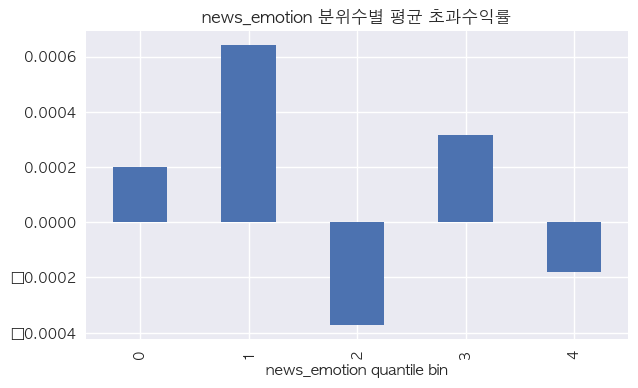

In [18]:
if "news_emotion" in train_df.columns:
    # 분위기 구간을 5 분위수로 나누고 각 구간별 평균/분산 확인
    train_df["news_bin"] = pd.qcut(train_df["news_emotion"], 5, labels=False, duplicates="drop")

    sent_stats = (
        train_df
        .groupby("news_bin")[target_col]
        .agg(["mean","std","count"])
    )
    print("=== news_emotion 분위수별 Target 통계 ===")
    display(sent_stats)

    plt.figure(figsize=(7, 4))
    sent_stats["mean"].plot(kind="bar")
    plt.title("news_emotion 분위수별 평균 초과수익률")
    plt.xlabel("news_emotion quantile bin")
    plt.show()

In [19]:
fe_df = df.copy()

# 타깃 lag
for l in [1, 2, 5, 10, 22]:
    fe_df[f"{target_col}_lag{l}"] = fe_df[target_col].shift(l)

# 21, 63일 rolling mean/std
for w in [21, 63]:
    fe_df[f"{target_col}_roll_mean_{w}"] = fe_df[target_col].rolling(w).mean()
    fe_df[f"{target_col}_roll_std_{w}"]  = fe_df[target_col].rolling(w).std()

# 변동성 레짐: 21일 vs 63일
fe_df["vol21"] = fe_df[target_col].rolling(21).std()
fe_df["vol63"] = fe_df[target_col].rolling(63).std()
fe_df["high_vol_regime"] = (fe_df["vol21"] > fe_df["vol63"]).astype(int)

# 캘린더 cyclical 인코딩
fe_df["month_sin"] = np.sin(2*np.pi*fe_df["month"]/12)
fe_df["month_cos"] = np.cos(2*np.pi*fe_df["month"]/12)
fe_df["dow_sin"]   = np.sin(2*np.pi*fe_df["dow"]/7)
fe_df["dow_cos"]   = np.cos(2*np.pi*fe_df["dow"]/7)

# 훈련/테스트 다시 분리
fe_train = fe_df[train_mask].copy()
fe_test  = fe_df[~train_mask].copy()

fe_train.tail(3)

,date,close,high,low,open,volume,ret_1d,ret_5d,ret_22d,ma_5,...,market_forward_excess_returns_roll_std_21,market_forward_excess_returns_roll_mean_63,market_forward_excess_returns_roll_std_63,vol21,vol63,high_vol_regime,month_sin,month_cos,dow_sin,dow_cos
4191,2021-12-17,3017.729980,3017.729980,2984.189941,2985.199951,451400,0.003765,0.002492,0.018671,3000.627930,...,0.011150,-0.001305,0.009937,0.011150,0.009937,1,-2.449294e-16,1.0,-0.433884,-0.900969
4192,2021-12-20,2963.000000,3001.330078,2962.070068,3001.330078,377100,-0.018136,-0.012880,0.005300,2992.895947,...,0.010711,-0.001123,0.009921,0.010711,0.009921,1,-2.449294e-16,1.0,0.000000,1.000000
4193,2021-12-21,2975.030029,2984.560059,2955.899902,2981.669922,410500,0.004060,-0.004324,0.001350,2990.311963,...,0.010683,-0.001125,0.009920,0.010683,0.009920,1,-2.449294e-16,1.0,0.781831,0.623490


### 그룹별 피쳐 EDA

In [20]:
PRICE_COLS = ["open","high","low","close",
              "ma_5","ma_20","ma_60","ma_120",
              "bb_middle","bb_upper","bb_lower"]

RETURN_COLS = ["ret_1d","ret_5d","ret_22d",
               "momentum_10","momentum_20","momentum_60",
               "drawdown_60","max_drawdown_60"]

VOL_COLS = ["volume","vol_22d","atr_14","vix"]

MACRO_COLS = ["usdkrw","gold_price"]

TA_COLS = ["rsi_14","macd","macd_signal","macd_hist"]

SENT_COLS = ["news_emotion"] if "news_emotion" in train_df.columns else []

GROUPS = {
    "Price": PRICE_COLS,
    "Returns": RETURN_COLS,
    "Volatility": VOL_COLS,
    "Macro": MACRO_COLS,
    "Technical (RSI/MACD)": TA_COLS,
    "Sentiment": SENT_COLS,
}

for name, cols in GROUPS.items():
    exists = [c for c in cols if c in train_df.columns]
    print(f"{name:20s}: {len(exists)} cols -> {exists}")

Price               : 11 cols -> ['open', 'high', 'low', 'close', 'ma_5', 'ma_20', 'ma_60', 'ma_120', 'bb_middle', 'bb_upper', 'bb_lower']
Returns             : 8 cols -> ['ret_1d', 'ret_5d', 'ret_22d', 'momentum_10', 'momentum_20', 'momentum_60', 'drawdown_60', 'max_drawdown_60']
Volatility          : 4 cols -> ['volume', 'vol_22d', 'atr_14', 'vix']
Macro               : 2 cols -> ['usdkrw', 'gold_price']
Technical (RSI/MACD): 4 cols -> ['rsi_14', 'macd', 'macd_signal', 'macd_hist']
Sentiment           : 1 cols -> ['news_emotion']


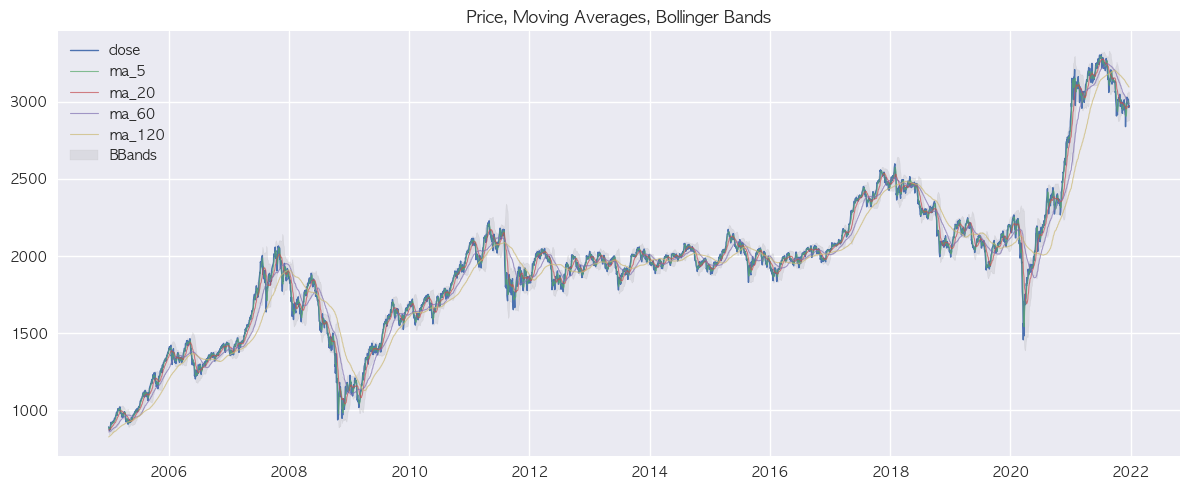

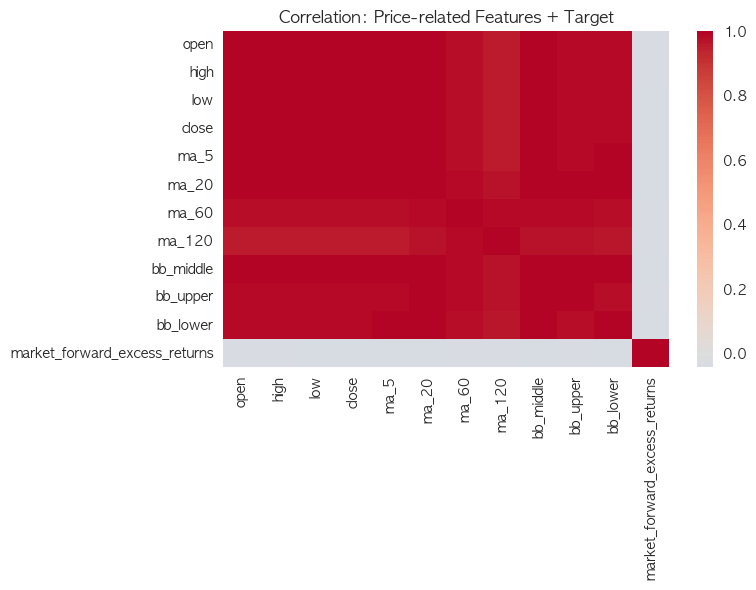

In [21]:
price_cols = [c for c in PRICE_COLS if c in train_df.columns]

fig, ax = plt.subplots(figsize=(12,5))
ax.plot(train_df["date"], train_df["close"], label="close", linewidth=1)

for ma in ["ma_5","ma_20","ma_60","ma_120"]:
    if ma in train_df.columns:
        ax.plot(train_df["date"], train_df[ma], label=ma, linewidth=0.8, alpha=0.7)

if "bb_upper" in train_df.columns and "bb_lower" in train_df.columns:
    ax.fill_between(train_df["date"], train_df["bb_lower"], train_df["bb_upper"],
                    color="gray", alpha=0.15, label="BBands")

ax.set_title("Price, Moving Averages, Bollinger Bands")
ax.legend()
plt.tight_layout()
plt.show()

# Price 그룹 + Target 상관 히트맵
cols_for_corr = [c for c in PRICE_COLS if c in train_df.columns] + [target_col]
corr_price = train_df[cols_for_corr].corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr_price, cmap="coolwarm", center=0)
plt.title("Correlation: Price-related Features + Target")
plt.tight_layout()
plt.show()


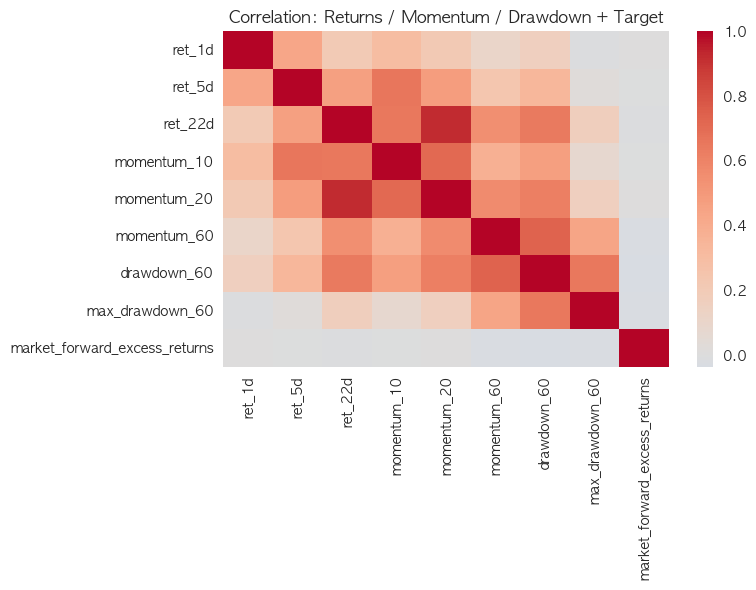

/Users/youjunglee/머러플_P4-2/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) AppleGothic.
  fig.canvas.print_figure(bytes_io, **kw)


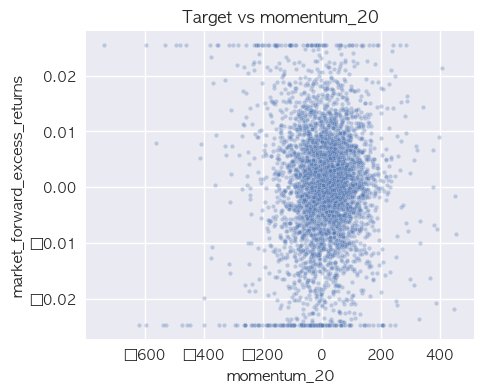

In [22]:
ret_cols = [c for c in RETURN_COLS if c in train_df.columns] + [target_col]
corr_ret = train_df[ret_cols].corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr_ret, cmap="coolwarm", center=0)
plt.title("Correlation: Returns / Momentum / Drawdown + Target")
plt.tight_layout()
plt.show()

# Target vs momentum_20 scatter (있으면)
if "momentum_20" in train_df.columns:
    plt.figure(figsize=(5,4))
    sns.scatterplot(x=train_df["momentum_20"], y=train_df[target_col], alpha=0.3, s=10)
    plt.title("Target vs momentum_20")
    plt.show()

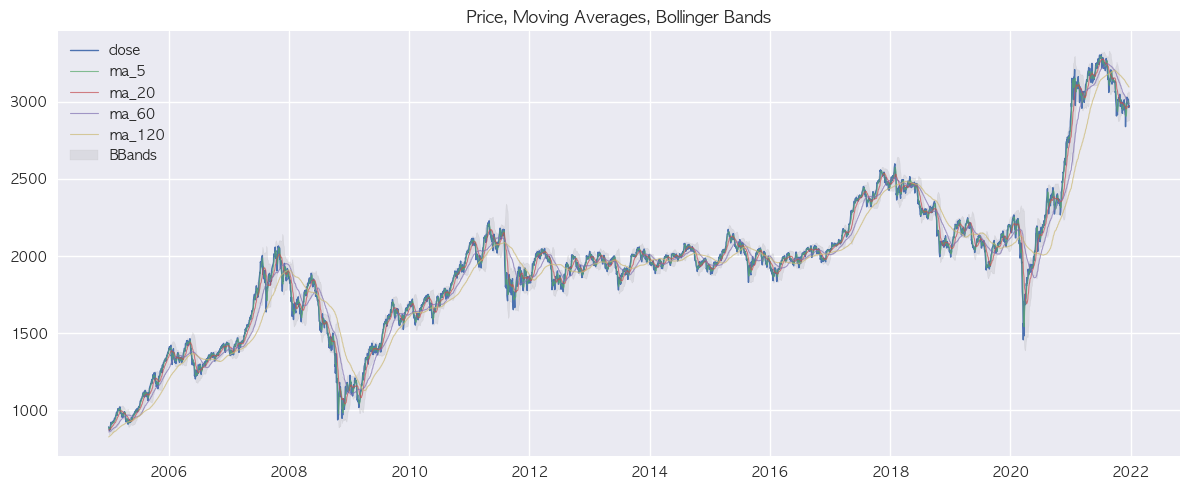

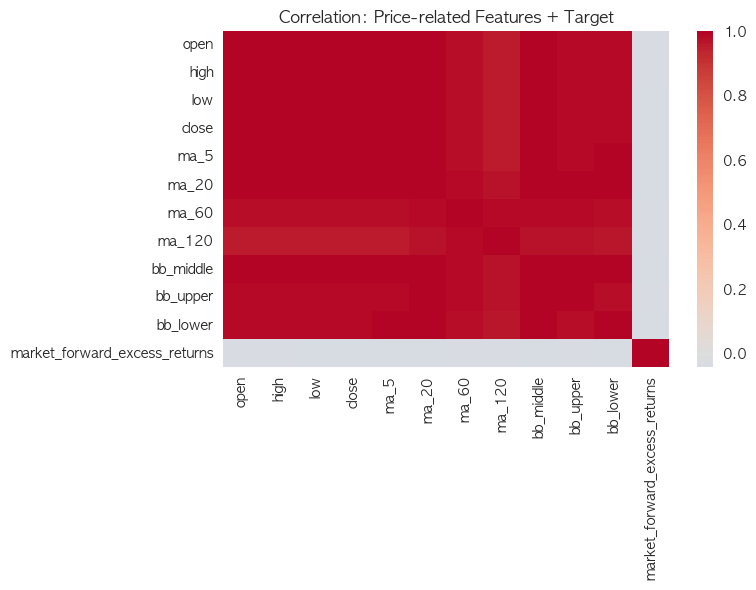

In [23]:
price_cols = [c for c in PRICE_COLS if c in train_df.columns]

fig, ax = plt.subplots(figsize=(12,5))
ax.plot(train_df["date"], train_df["close"], label="close", linewidth=1)

for ma in ["ma_5","ma_20","ma_60","ma_120"]:
    if ma in train_df.columns:
        ax.plot(train_df["date"], train_df[ma], label=ma, linewidth=0.8, alpha=0.7)

if "bb_upper" in train_df.columns and "bb_lower" in train_df.columns:
    ax.fill_between(train_df["date"], train_df["bb_lower"], train_df["bb_upper"],
                    color="gray", alpha=0.15, label="BBands")

ax.set_title("Price, Moving Averages, Bollinger Bands")
ax.legend()
plt.tight_layout()
plt.show()

# Price 그룹 + Target 상관 히트맵
cols_for_corr = [c for c in PRICE_COLS if c in train_df.columns] + [target_col]
corr_price = train_df[cols_for_corr].corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr_price, cmap="coolwarm", center=0)
plt.title("Correlation: Price-related Features + Target")
plt.tight_layout()
plt.show()


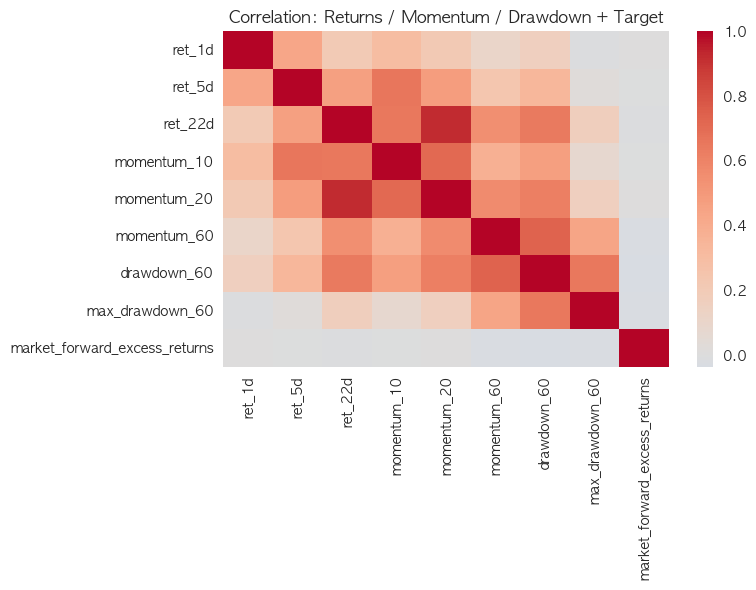

/Users/youjunglee/머러플_P4-2/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) AppleGothic.
  fig.canvas.print_figure(bytes_io, **kw)


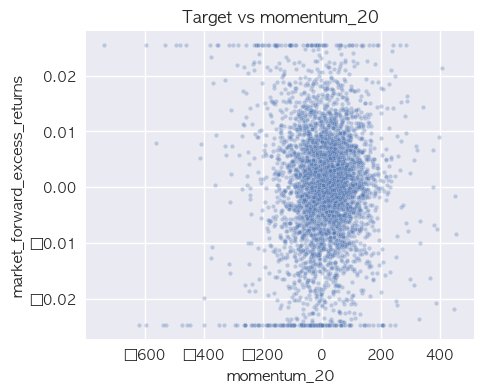

In [24]:
ret_cols = [c for c in RETURN_COLS if c in train_df.columns] + [target_col]
corr_ret = train_df[ret_cols].corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr_ret, cmap="coolwarm", center=0)
plt.title("Correlation: Returns / Momentum / Drawdown + Target")
plt.tight_layout()
plt.show()

# Target vs momentum_20 scatter (있으면)
if "momentum_20" in train_df.columns:
    plt.figure(figsize=(5,4))
    sns.scatterplot(x=train_df["momentum_20"], y=train_df[target_col], alpha=0.3, s=10)
    plt.title("Target vs momentum_20")
    plt.show()

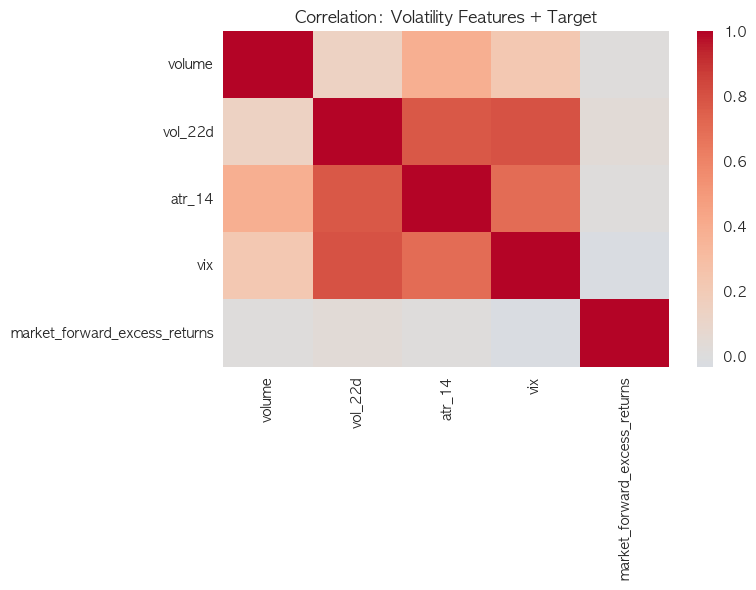

/var/folders/_x/1dj45gqx4m95yc49m_ty7t_00000gn/T/ipykernel_7343/2699304668.py:20: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) AppleGothic.
  plt.tight_layout()
/Users/youjunglee/머러플_P4-2/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) AppleGothic.
  fig.canvas.print_figure(bytes_io, **kw)


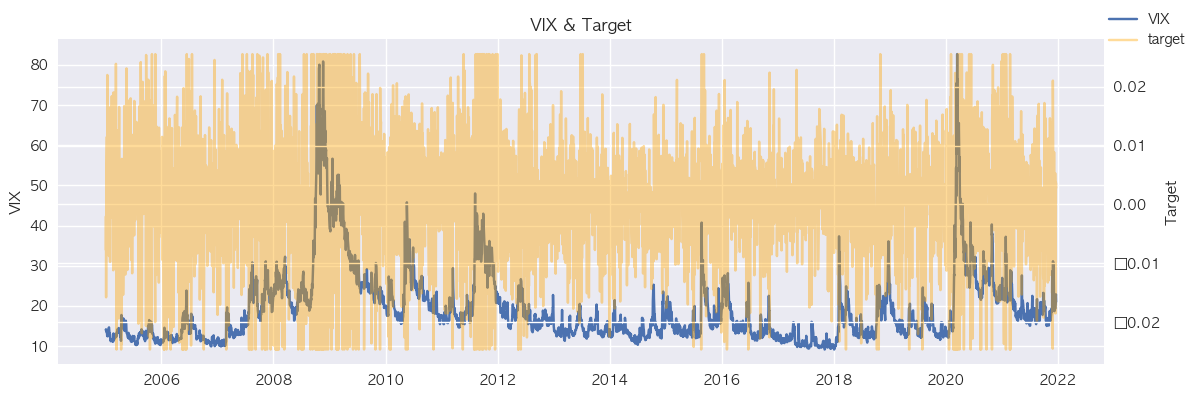

In [25]:
vol_cols = [c for c in VOL_COLS if c in train_df.columns] + [target_col]
corr_vol = train_df[vol_cols].corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr_vol, cmap="coolwarm", center=0)
plt.title("Correlation: Volatility Features + Target")
plt.tight_layout()
plt.show()

# VIX & vol_22d 타임시리즈
if "vix" in train_df.columns:
    fig, ax1 = plt.subplots(figsize=(12,4))
    ax1.plot(train_df["date"], train_df["vix"], label="VIX")
    ax1.set_ylabel("VIX")
    ax1.set_title("VIX & Target")
    ax2 = ax1.twinx()
    ax2.plot(train_df["date"], train_df[target_col], color="orange", alpha=0.4, label="target")
    ax2.set_ylabel("Target")
    fig.legend(loc="upper right")
    plt.tight_layout()
    plt.show()

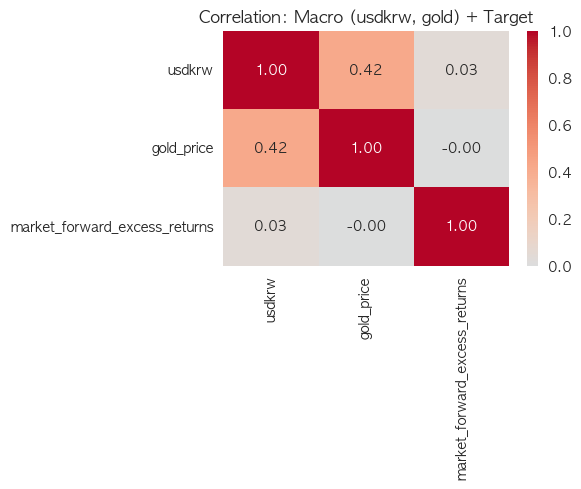

=== usdkrw 분위수별 Target 통계 ===


,mean,std,count
usdkrw_bin,,,
0,0.000133,0.011207,839
1,-0.000427,0.009277,839
2,-0.000069,0.008522,838
3,0.000161,0.009508,839
4,0.000806,0.012375,839


/Users/youjunglee/머러플_P4-2/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) AppleGothic.
  fig.canvas.print_figure(bytes_io, **kw)


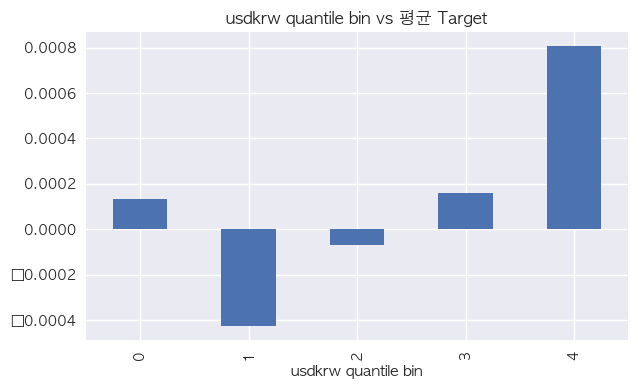

In [26]:
macro_cols = [c for c in MACRO_COLS if c in train_df.columns] + [target_col]
if len(macro_cols) > 1:
    corr_macro = train_df[macro_cols].corr()
    plt.figure(figsize=(6,5))
    sns.heatmap(corr_macro, cmap="coolwarm", center=0, annot=True, fmt=".2f")
    plt.title("Correlation: Macro (usdkrw, gold) + Target")
    plt.tight_layout()
    plt.show()

    # quantile bin별 Target 평균 (예: usdkrw)
    if "usdkrw" in train_df.columns:
        train_df["usdkrw_bin"] = pd.qcut(train_df["usdkrw"], 5, labels=False, duplicates="drop")
        stats_krw = train_df.groupby("usdkrw_bin")[target_col].agg(["mean","std","count"])
        print("=== usdkrw 분위수별 Target 통계 ===")
        display(stats_krw)

        plt.figure(figsize=(7,4))
        stats_krw["mean"].plot(kind="bar")
        plt.title("usdkrw quantile bin vs 평균 Target")
        plt.xlabel("usdkrw quantile bin")
        plt.show()


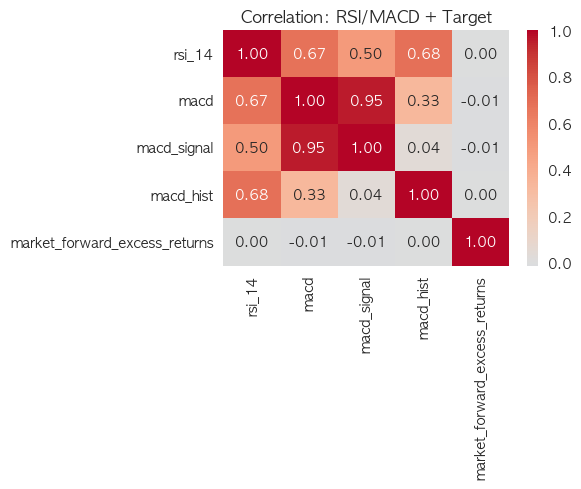

=== RSI regime별 Target 통계 ===


/var/folders/_x/1dj45gqx4m95yc49m_ty7t_00000gn/T/ipykernel_7343/35684392.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rsi_stats = train_df.groupby("rsi_regime")[target_col].agg(["mean","std","count"])


,mean,std,count
rsi_regime,,,
oversold,-0.000300,0.013846,372
low,0.000249,0.011145,968
mid,0.000391,0.010068,824
high,-0.000258,0.009447,1217
overbought,0.000454,0.008550,813


/Users/youjunglee/머러플_P4-2/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) AppleGothic.
  fig.canvas.print_figure(bytes_io, **kw)


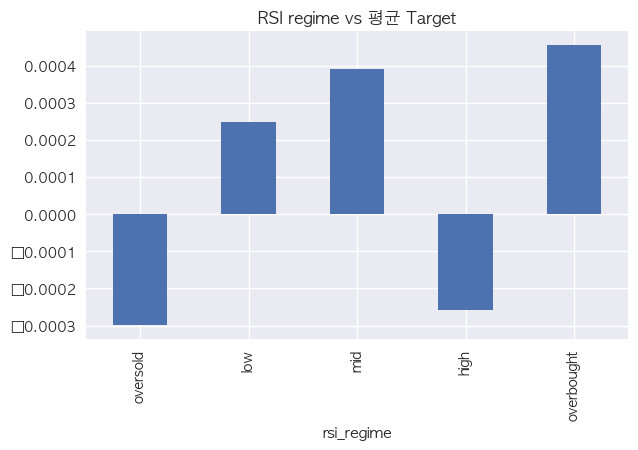

=== MACD_Hist sign별 Target 통계 ===


,mean,std,count
macd_sign,,,
-1.0,-0.000099,0.011297,1997
1.0,0.000321,0.009253,2197


=== news_emotion 분위수별 Target 통계 ===


,mean,std,count
news_bin,,,
0,0.000199,0.013198,839
1,0.000641,0.010048,841
2,-0.000373,0.009611,839
3,0.000316,0.009096,837
4,-0.000180,0.008816,838


/Users/youjunglee/머러플_P4-2/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) AppleGothic.
  fig.canvas.print_figure(bytes_io, **kw)


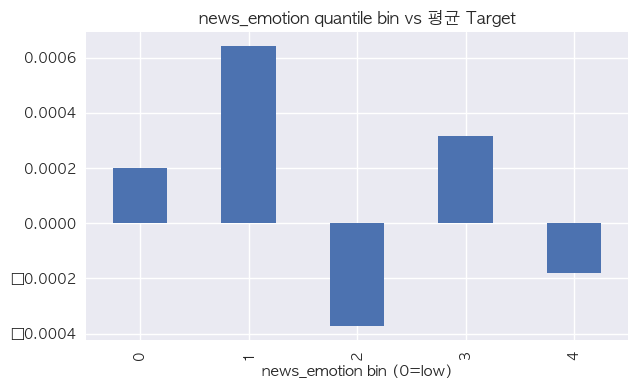

In [27]:
ta_cols = [c for c in TA_COLS if c in train_df.columns] + [target_col]
if len(ta_cols) > 1:
    corr_ta = train_df[ta_cols].corr()
    plt.figure(figsize=(6,5))
    sns.heatmap(corr_ta, cmap="coolwarm", center=0, annot=True, fmt=".2f")
    plt.title("Correlation: RSI/MACD + Target")
    plt.tight_layout()
    plt.show()

# RSI regime vs Target
if "rsi_14" in train_df.columns:
    bins = [0, 30, 45, 55, 70, 100]
    labels = ["oversold","low","mid","high","overbought"]
    train_df["rsi_regime"] = pd.cut(train_df["rsi_14"], bins=bins, labels=labels, include_lowest=True)
    rsi_stats = train_df.groupby("rsi_regime")[target_col].agg(["mean","std","count"])
    print("=== RSI regime별 Target 통계 ===")
    display(rsi_stats)

    plt.figure(figsize=(7,4))
    rsi_stats["mean"].plot(kind="bar")
    plt.title("RSI regime vs 평균 Target")
    plt.show()

# MACD hist sign vs Target
if "macd_hist" in train_df.columns:
    train_df["macd_sign"] = np.sign(train_df["macd_hist"])
    macd_stats = train_df.groupby("macd_sign")[target_col].agg(["mean","std","count"])
    print("=== MACD_Hist sign별 Target 통계 ===")
    display(macd_stats)


if "news_emotion" in train_df.columns:
    train_df["news_bin"] = pd.qcut(train_df["news_emotion"], 5, labels=False, duplicates="drop")
    sent_stats = train_df.groupby("news_bin")[target_col].agg(["mean","std","count"])
    print("=== news_emotion 분위수별 Target 통계 ===")
    display(sent_stats)

    plt.figure(figsize=(7,4))
    sent_stats["mean"].plot(kind="bar")
    plt.title("news_emotion quantile bin vs 평균 Target")
    plt.xlabel("news_emotion bin (0=low)")
    plt.show()

In [46]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# 숫자형 전체
X = df.select_dtypes(include=[np.number]).copy()

# 결측치 처리 (VIF 계산 위해)
X = X.fillna(method='ffill').fillna(method='bfill')

vif_df = pd.DataFrame()
vif_df["feature"] = X.columns
vif_df["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

vif_df = vif_df.sort_values("VIF", ascending=False)
display(vif_df.head(30))

/var/folders/_x/1dj45gqx4m95yc49m_ty7t_00000gn/T/ipykernel_13706/908936912.py:7: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = X.fillna(method='ffill').fillna(method='bfill')
/Users/youjunglee/머러플_P4-2/.venv/lib/python3.11/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


,feature,VIF
14,macd,inf
15,macd_signal,4.503600e+15
38,dow,1.801440e+15
19,bb_upper,1.286743e+15
20,bb_lower,2.649176e+14
35,dayofweek,1.501200e+14
16,macd_hist,1.364727e+14
18,bb_middle,4.039103e+13
9,ma_20,1.063424e+13
0,close,2.013528e+05


In [29]:
df = df.sort_values("date").reset_index(drop=True)

num_cols_all = df.select_dtypes(include=[np.number]).columns.tolist()

leak_like_cols = [
    "close", "open", "high", "low",
]

target_cols = [
    "forward_return",
    "forward_returns",
    "risk_free_rate",
    "market_forward_excess_returns",
    "rolling_5yr_mean",
]

calendar_cols = [
    "year", "month", "day", "dow",
    "week_of_month", "dayofweek",
]

meta_cols = [
    "is_train",
]

drop_cols = leak_like_cols + target_cols + calendar_cols + meta_cols
drop_cols = [c for c in drop_cols if c in num_cols_all]

print("제외할 컬럼들:", drop_cols)

# 3) 최종 Feature set X
feature_cols = [c for c in num_cols_all if c not in drop_cols]
print("최종 feature 개수:", len(feature_cols))
print("예시:", feature_cols[:15])

X = df[feature_cols].copy()

# VIF/PCA 계산 위해 결측치 처리 (전방/후방 채움 → 남는 NaN 있으면 0)
X = X.fillna(method="ffill").fillna(method="bfill").fillna(0.0)

X.shape


제외할 컬럼들: ['close', 'open', 'high', 'low', 'forward_return', 'market_forward_excess_returns', 'rolling_5yr_mean', 'year', 'month', 'day', 'dow', 'week_of_month', 'is_train']
최종 feature 개수: 26
예시: ['volume', 'ret_1d', 'ret_5d', 'ret_22d', 'ma_5', 'ma_20', 'ma_60', 'ma_120', 'vol_22d', 'rsi_14', 'macd', 'macd_signal', 'macd_hist', 'atr_14', 'bb_middle']


/var/folders/_x/1dj45gqx4m95yc49m_ty7t_00000gn/T/ipykernel_7343/2571085565.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = X.fillna(method="ffill").fillna(method="bfill").fillna(0.0)


(4933, 26)

In [30]:
vif_df = pd.DataFrame()
vif_df["feature"] = X.columns
vif_df["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

vif_df = vif_df.sort_values("VIF", ascending=False)
display(vif_df.head(30))

NameError: name 'variance_inflation_factor' is not defined

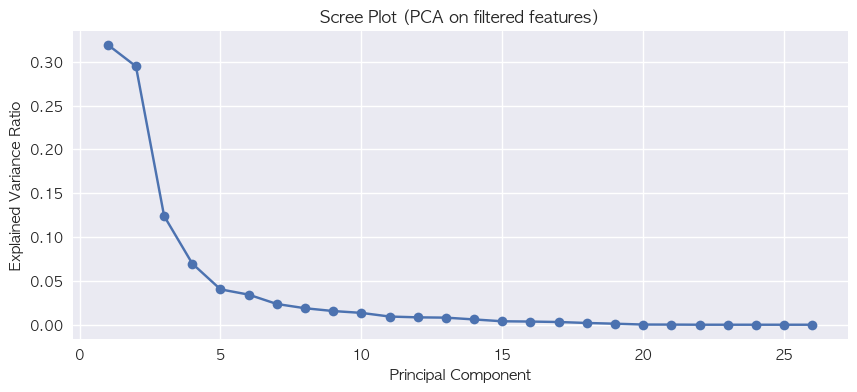

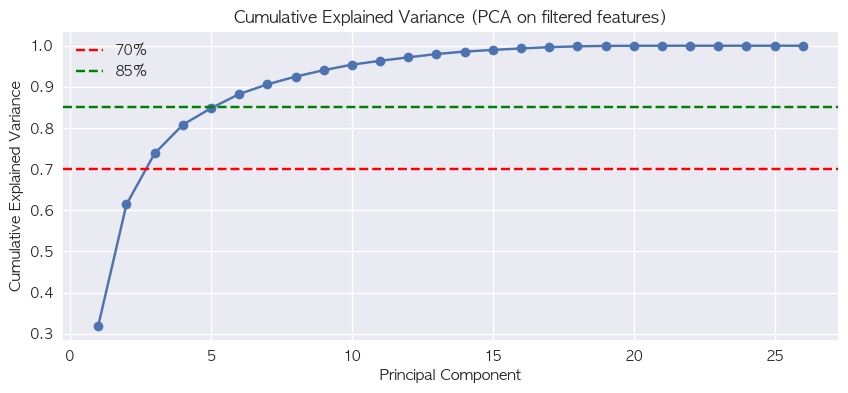

Eigenvalue > 1 인 성분 개수 (Kaiser rule): 5


In [31]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# 1) 스케일링
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 2) PCA 전체 적합
pca = PCA()
pca.fit(X_scaled)

explained = pca.explained_variance_ratio_
cum_explained = np.cumsum(explained)

# Scree Plot
plt.figure(figsize=(10, 4))
plt.plot(np.arange(1, len(explained)+1), explained, marker="o")
plt.title("Scree Plot (PCA on filtered features)")
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance Ratio")
plt.grid(True)
plt.show()

# Cumulative Plot
plt.figure(figsize=(10, 4))
plt.plot(np.arange(1, len(cum_explained)+1), cum_explained, marker="o")
plt.axhline(0.70, linestyle="--", color="red", label="70%")
plt.axhline(0.85, linestyle="--", color="green", label="85%")
plt.title("Cumulative Explained Variance (PCA on filtered features)")
plt.xlabel("Principal Component")
plt.ylabel("Cumulative Explained Variance")
plt.legend()
plt.grid(True)
plt.show()

# 고유값(eigenvalue) > 1 기준 성분 개수 (Kaiser rule)
eigenvalues = pca.explained_variance_
kaiser_count = (eigenvalues > 1).sum()
print("Eigenvalue > 1 인 성분 개수 (Kaiser rule):", kaiser_count)


/Users/youjunglee/머러플_P4-2/.venv/lib/python3.11/site-packages/seaborn/utils.py:61: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) AppleGothic.
  fig.canvas.draw()
/Users/youjunglee/머러플_P4-2/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) AppleGothic.
  fig.canvas.print_figure(bytes_io, **kw)


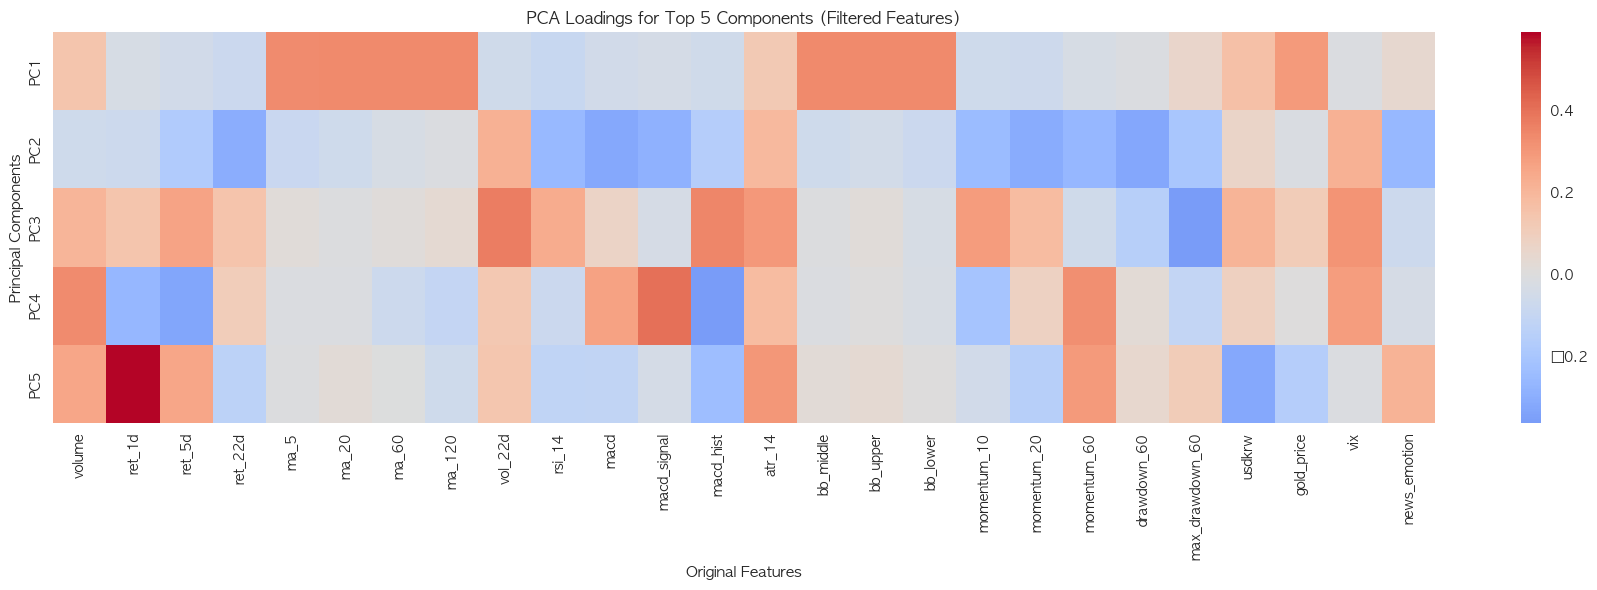

,volume,ret_1d,ret_5d,ret_22d,ma_5,ma_20,ma_60,ma_120,vol_22d,rsi_14,...,bb_lower,momentum_10,momentum_20,momentum_60,drawdown_60,max_drawdown_60,usdkrw,gold_price,vix,news_emotion
PC1,0.145972,-0.028209,-0.056180,-0.075974,0.334883,0.340466,0.342316,0.338986,-0.059609,-0.086170,...,0.336539,-0.063240,-0.063812,-0.027600,-0.009245,0.055668,0.165629,0.293879,-0.009816,0.047344
PC2,-0.061224,-0.074190,-0.173862,-0.299003,-0.085987,-0.060198,-0.028528,-0.007927,0.218236,-0.255075,...,-0.075014,-0.248645,-0.302856,-0.264076,-0.322444,-0.199868,0.070059,-0.017247,0.219256,-0.258132
PC3,0.207949,0.146980,0.267397,0.152038,0.015331,-0.005493,0.012446,0.035687,0.368901,0.237954,...,-0.029945,0.288148,0.184649,-0.056958,-0.146252,-0.359497,0.210313,0.111694,0.311605,-0.072471
PC4,0.331983,-0.264131,-0.330457,0.110798,-0.013606,-0.012610,-0.074902,-0.102413,0.131956,-0.077767,...,-0.025841,-0.206377,0.085612,0.324955,0.025971,-0.106841,0.090888,0.000015,0.284032,-0.035313
PC5,0.255736,0.592554,0.255450,-0.129242,-0.005723,0.018476,-0.003295,-0.061462,0.140139,-0.118853,...,-0.000073,-0.049472,-0.148504,0.292608,0.048895,0.115211,-0.317665,-0.160535,-0.011772,0.215811


In [32]:
K = 5
loadings = pd.DataFrame(
    pca.components_[:K],
    columns=X.columns,
    index=[f"PC{i+1}" for i in range(K)]
)

plt.figure(figsize=(18, 6))
sns.heatmap(loadings, cmap="coolwarm", center=0)
plt.title("PCA Loadings for Top 5 Components (Filtered Features)")
plt.xlabel("Original Features")
plt.ylabel("Principal Components")
plt.tight_layout()
plt.show()

loadings


In [33]:
# PCA transform → 각 PC의 시계열(time series factor) 생성
PC = pca.transform(X_scaled)[:, :5]

pc_df = pd.DataFrame(
    PC,
    columns=[f"PC{i+1}" for i in range(5)],
    index=df.index
)

pc_df["date"] = df["date"].values

pc_df.head()

,PC1,PC2,PC3,PC4,PC5,date
0,-6.733670,-0.644486,-0.802388,-0.483724,-0.288284,2005-01-03
1,-6.577842,-0.303260,-1.054087,-0.153769,-0.396537,2005-01-04
2,-6.516199,-0.207278,-1.165419,-0.098961,-0.047333,2005-01-05
3,-6.270043,0.549966,-1.814915,0.638254,-0.733561,2005-01-06
4,-6.347510,0.471792,-1.869944,0.380231,-0.190851,2005-01-07


/var/folders/_x/1dj45gqx4m95yc49m_ty7t_00000gn/T/ipykernel_7343/2548571939.py:9: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) AppleGothic.
  plt.tight_layout()
/Users/youjunglee/머러플_P4-2/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) AppleGothic.
  fig.canvas.print_figure(bytes_io, **kw)


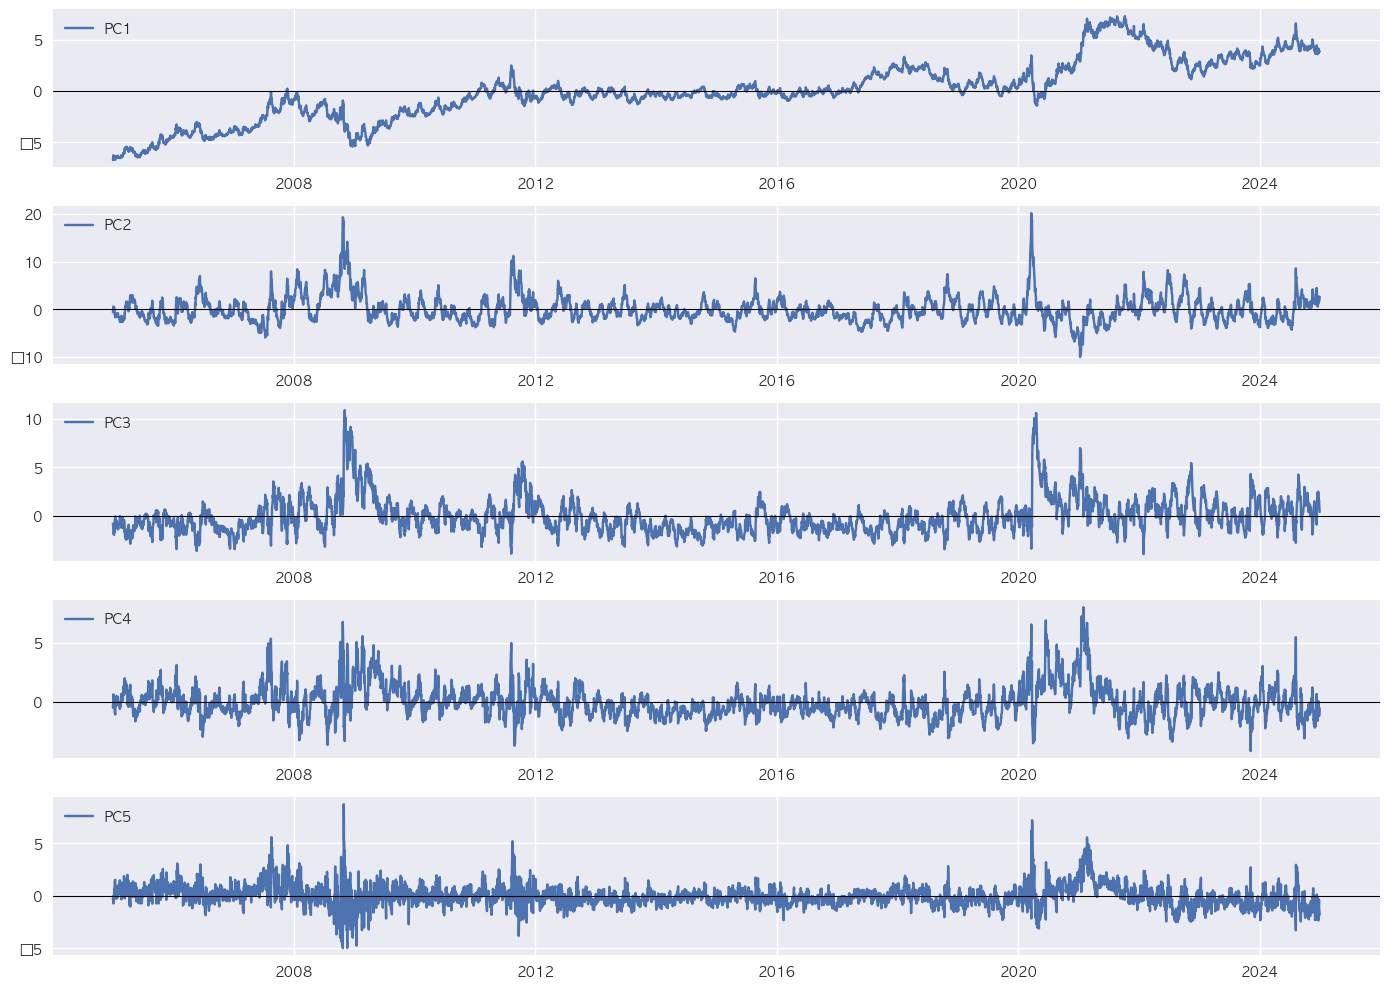

In [34]:
plt.figure(figsize=(14, 10))

for i in range(5):
    plt.subplot(5,1,i+1)
    plt.plot(pc_df["date"], pc_df[f"PC{i+1}"], label=f"PC{i+1}")
    plt.axhline(0, color='black', linewidth=0.8)
    plt.legend(loc="upper left")

plt.tight_layout()
plt.show()
